In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


import the test image

In [2]:
img_path = 'test_img/cat_dog.jpg'

In [3]:
img_pil = Image.open(img_path)

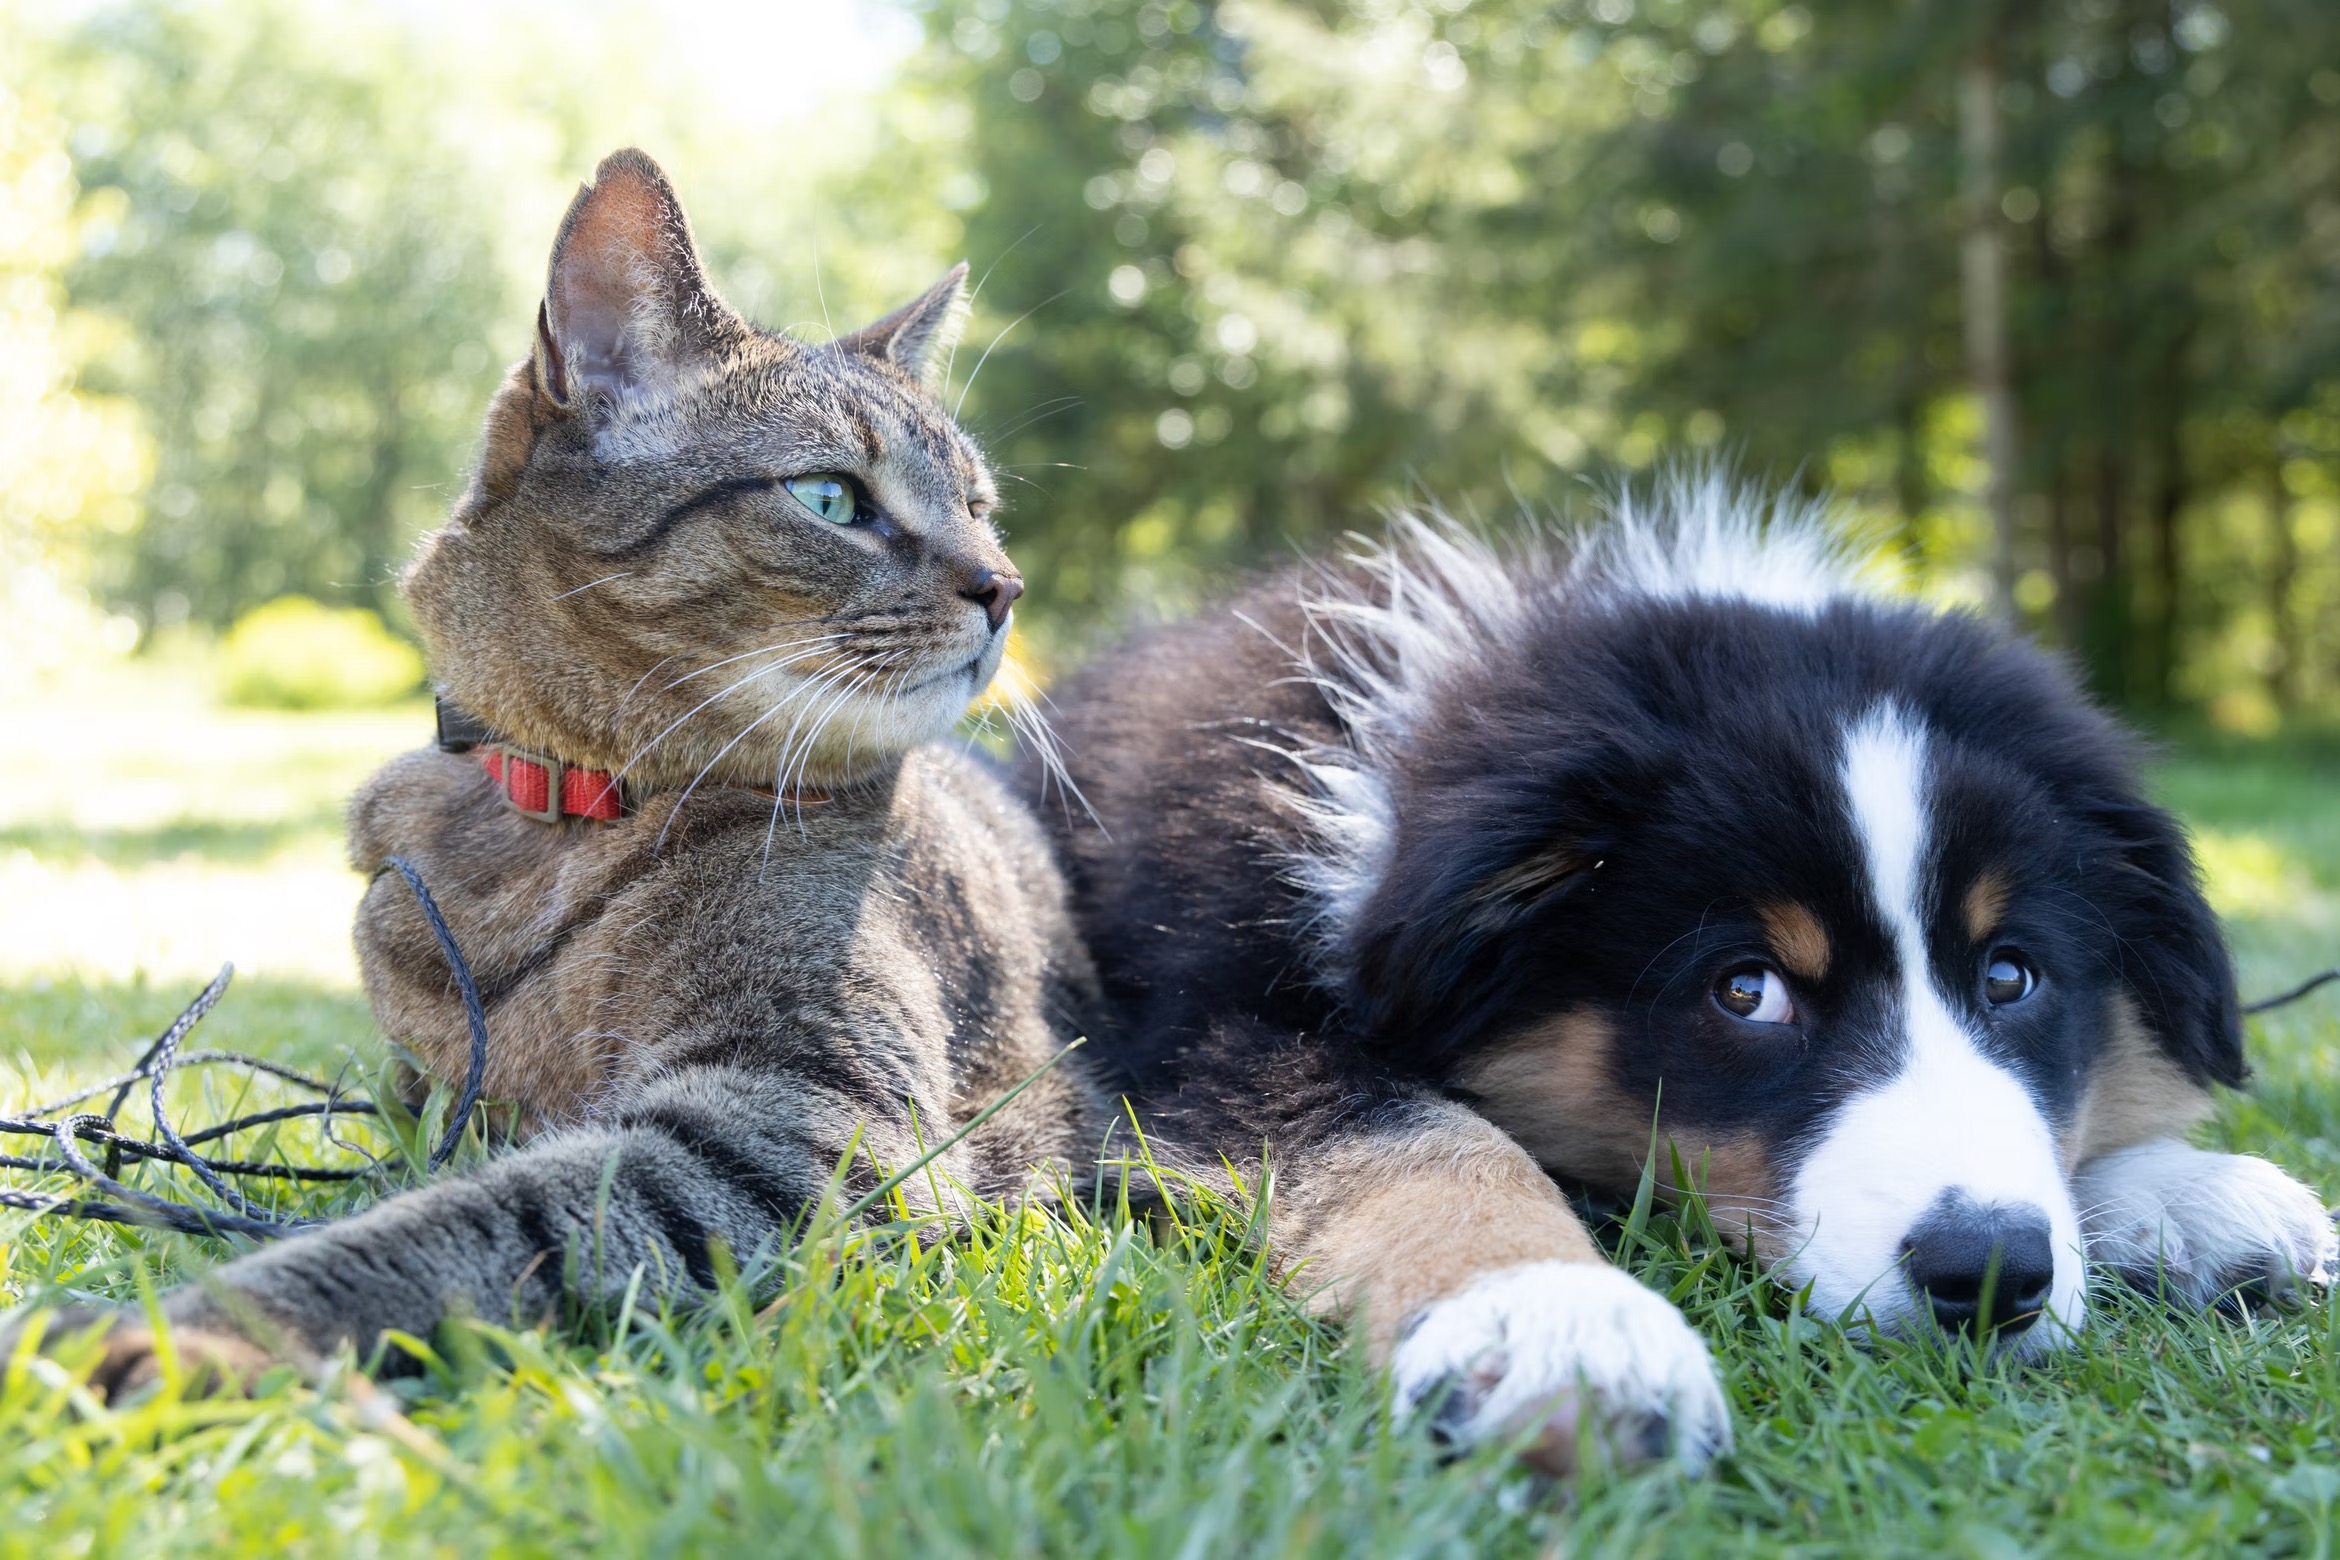

In [4]:
img_pil

In [5]:
model = models.inception_v3(weights=True).eval().to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

In [7]:
trans_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

trans_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    trans_norm
    ])

trans_B = transforms.Compose([
        transforms.ToTensor(),
        trans_norm
    ])

trans_C = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

In [8]:
input_tensor = trans_A(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)
top_n = pred_softmax.topk(5)

In [9]:
top_n

torch.return_types.topk(
values=tensor([[0.4491, 0.1488, 0.1225, 0.0850, 0.0702]], grad_fn=<TopkBackward0>),
indices=tensor([[231, 230, 281, 239, 282]]))

In [10]:
def batch_predict(images):
    batch = torch.stack(tuple(trans_B(i) for i in images), dim=0)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [11]:
test_pred = batch_predict([trans_C(img_pil)])
test_pred.squeeze().argmax()

231

In [12]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer(random_state= 42)
explanation = explainer.explain_instance(np.array(trans_C(img_pil)), 
                                         batch_predict,
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
explanation.top_labels[0]

231

In [14]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

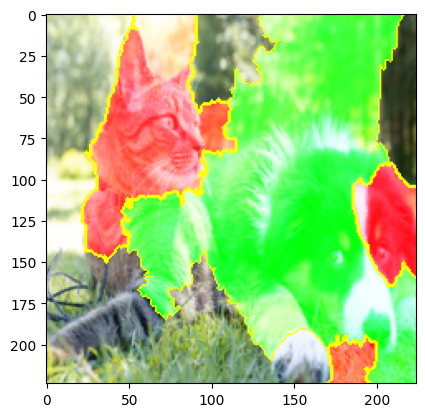

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)

output_path = "results/collie_explanation.png" 
plt.imsave(output_path, img_boundry)
plt.imshow(img_boundry)
plt.show()

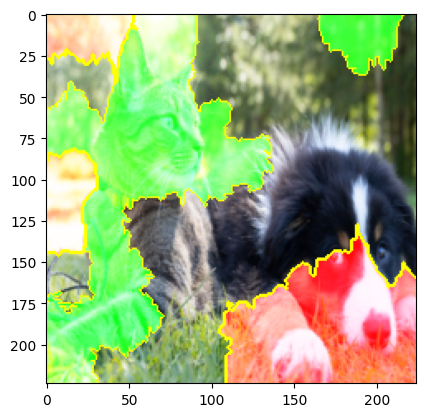

In [16]:
temp, mask = explanation.get_image_and_mask(281, positive_only=False, num_features=20, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
output_path = "results/tabby_explanation.png" 
plt.imsave(output_path, img_boundry2)
plt.imshow(img_boundry2)
plt.show()